# VSL Recognition on Gloss Videos

## Setup and Data Extraction

In [ ]:
!pip install numpy opencv-python tqdm torch mediapipe scikit-learn matplotlib

INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
# Core libraries for data handling and processing
import os
import zipfile
import unicodedata
import numpy as np
import cv2
from tqdm.notebook import tqdm
import collections
import random

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# MediaPipe
import mediapipe as mp

# Scikit-learn & Plotting
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
compressed_file_path = '/content/drive/MyDrive/VSL/vsl-vocab-demo.zip' # Adjust if your path is different
extracted_dir_path = '/content/vsl_dataset' # The main folder where content will be extracted

# Start with a clean slate
if os.path.exists(extracted_dir_path):
    !rm -rf {extracted_dir_path}
os.makedirs(extracted_dir_path, exist_ok=True)

print(f"Extracting '{compressed_file_path}'...")
with zipfile.ZipFile(compressed_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
print(f"Successfully extracted dataset to '{extracted_dir_path}'")

Extracting '/content/drive/MyDrive/VSL/vsl-vocab-demo.zip'...
Successfully extracted dataset to '/content/vsl_dataset'


## Pre-processing

In [ ]:
# --- CONFIGURATION ---
# The pipeline will search for videos and data.txt inside this folder
BASE_DATA_FOLDER = extracted_dir_path
OUTPUT_NPY_FOLDER = '/content/vsl_keypoints_augmented'
NUM_AUGMENTED_COPIES = 6
SEQUENCE_LENGTH = 30
NUM_FEATURES = 1662

# Automatically find the data.txt file
LABELS_FILE_PATH = None
for root, dirs, files in os.walk(BASE_DATA_FOLDER):
    if 'data.txt' in files:
        LABELS_FILE_PATH = os.path.join(root, 'data.txt')
        break

if LABELS_FILE_PATH:
    print(f"Found label mapping file at: {LABELS_FILE_PATH}")
else:
    print("Error: data.txt not found in the extracted directory.")

Found label mapping file at: /content/vsl_dataset/vsl-vocab-demo/data.txt


## Pose Landmarks

In [ ]:
# Keep only the upper body, ignoring the legs and feet (indices 25-32).
# This captures the torso, shoulders, arms, and head, which are most relevant for VSL.
UPPER_BODY_POSE_INDICES = list(range(25))

# Create a focused set of 11 face landmarks for the mouth, lips, and nose.
# This captures essential facial expressions for sign language while minimizing irrelevant features.
MINIMAL_FACE_INDICES = sorted(list(set([

    # --- Key Mouth Anchor Points ---
    0,   # Center point on the outer edge of the upper lip.
    17,  # Center point on the outer edge of the lower lip.
    61,  # Left corner of the mouth (from the subject's perspective).
    291, # Right corner of the mouth (from the subject's perspective).

    # --- Upper Lip Contour (to capture shape and expression) ---
    40, 39, 37,      # Points tracing the curve of the upper lip on the subject's right side.
    270, 269, 267,   # Points tracing the curve of the upper lip on the subject's left side.

    # --- Stable Face Anchor ---
    1,   # Tip of the nose, a stable point for tracking head orientation.

])))

# --- Calculate the new feature counts ---
NUM_POSE_LANDMARKS = len(UPPER_BODY_POSE_INDICES) # 25
NUM_FACE_LANDMARKS = len(MINIMAL_FACE_INDICES)   # 11
NUM_HAND_LANDMARKS = 21

# This is the total number of landmarks that will be processed in each frame.
TOTAL_LANDMARKS = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS + (2 * NUM_HAND_LANDMARKS)

# We use 4 coordinates (x, y, z, visibility) for all landmarks for consistency in the data structure.
LANDMARK_DIM = 4

print(f"Using a structured data format with {TOTAL_LANDMARKS} landmarks per frame.")

Using a structured data format with 78 landmarks per frame.


In [ ]:
def extract_keypoints_structured(results):
    """Extracts keypoints into a structured [num_landmarks, 4] numpy array."""
    all_landmarks = np.zeros((TOTAL_LANDMARKS, LANDMARK_DIM)) # Initialize with zeros

    # Fill in data for each part, maintaining order
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        for i, idx in enumerate(UPPER_BODY_POSE_INDICES):
            all_landmarks[i] = [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z, landmarks[idx].visibility]

    if results.face_landmarks:
        landmarks = results.face_landmarks.landmark
        offset = NUM_POSE_LANDMARKS
        for i, idx in enumerate(MINIMAL_FACE_INDICES):
            all_landmarks[offset + i] = [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z, 1.0]

    if results.left_hand_landmarks:
        landmarks = results.left_hand_landmarks.landmark
        offset = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS
        for i, res in enumerate(landmarks):
            all_landmarks[offset + i] = [res.x, res.y, res.z, 1.0]

    if results.right_hand_landmarks:
        landmarks = results.right_hand_landmarks.landmark
        offset = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS + NUM_HAND_LANDMARKS
        for i, res in enumerate(landmarks):
            all_landmarks[offset + i] = [res.x, res.y, res.z, 1.0]

    return all_landmarks

def augment_keypoints_structured(sequence):
    """Applies augmentations to a structured sequence of shape (seq_len, num_landmarks, landmark_dim)."""
    aug_sequence = sequence.copy()

    # 1. Noise Injection
    aug_sequence += np.random.normal(0, 0.005, size=aug_sequence.shape)

    # 2. Scaling & Translation (now much simpler)
    scale_factor = np.random.uniform(0.9, 1.1)
    trans_x, trans_y = np.random.uniform(-0.05, 0.05, 2)
    aug_sequence[:, :, 0:2] *= scale_factor # Scale x and y
    aug_sequence[:, :, 0] += trans_x     # Translate x
    aug_sequence[:, :, 1] += trans_y     # Translate y

    return aug_sequence.astype(np.float32)

In [ ]:
def create_structured_npy_dataset():
    """
    Processes videos and saves all .npy files with a STANDARDIZED sequence length.
    """
    OUTPUT_NPY_FOLDER = '/content/vsl_keypoints_structured'
    # Use the SEQUENCE_LENGTH defined in your config (e.g., 30)

    if os.path.exists(OUTPUT_NPY_FOLDER):
        !rm -rf {OUTPUT_NPY_FOLDER}
    os.makedirs(OUTPUT_NPY_FOLDER, exist_ok=True)

    video_to_label_map = {}
    with open(LABELS_FILE_PATH, 'r', encoding='utf-8-sig') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                filename, label = line.split(',')
                video_to_label_map[filename.strip()] = label.strip()

    holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    for video_filename, clean_label in tqdm(video_to_label_map.items(), desc="Processing Videos"):
        video_path = None
        for root, dirs, files in os.walk(extracted_dir_path):
            if video_filename in files:
                video_path = os.path.join(root, video_filename)
                break
        if not video_path:
            print(f"Warning: Video '{video_filename}' not found. Skipping.")
            continue

        cap = cv2.VideoCapture(video_path)
        frame_keypoints = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frame_keypoints.append(extract_keypoints_structured(results))
        cap.release()

        if len(frame_keypoints) > 0:
            # --- FIX: PAD OR TRUNCATE TO A FIXED LENGTH HERE ---
            sequence = np.array(frame_keypoints)
            fixed_length_sequence = np.zeros((SEQUENCE_LENGTH, TOTAL_LANDMARKS, LANDMARK_DIM))

            if sequence.shape[0] > SEQUENCE_LENGTH:
                # Truncate by taking evenly spaced frames
                indices = np.linspace(0, sequence.shape[0] - 1, SEQUENCE_LENGTH, dtype=int)
                fixed_length_sequence = sequence[indices]
            else:
                # Pad with zeros at the end
                fixed_length_sequence[:sequence.shape[0]] = sequence
            # --- END OF FIX ---

            unique_id = video_filename.split('.')[0]
            # Save the fixed-length original sequence
            np.save(os.path.join(OUTPUT_NPY_FOLDER, f"{clean_label}_{unique_id}_original.npy"), fixed_length_sequence)

            # Create augmented versions from the fixed-length sequence
            for i in range(NUM_AUGMENTED_COPIES): # Or your desired number of copies
                augmented_sequence = augment_keypoints_structured(fixed_length_sequence)
                np.save(os.path.join(OUTPUT_NPY_FOLDER, f"{clean_label}_{unique_id}_aug_{i+1}.npy"), augmented_sequence)

    holistic.close()
    print(f"\nCreated {len(os.listdir(OUTPUT_NPY_FOLDER))} standardized .npy files.")
    return OUTPUT_NPY_FOLDER

# --- RUN THE SCRIPT ---
KEYPOINT_DATA_PATH = create_structured_npy_dataset()

Processing Videos:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



Created 140 standardized .npy files.


## Training & Inference

In [ ]:
# --- CONFIGURATION ---
MODEL_SAVE_PATH = 'vsl_attention_lstm_model.pth'
SEQUENCE_LENGTH = 30 # We will pad/truncate to this length in the Dataset

label_to_int = {
    'hài_lòng': 0,
    'kỹ_năng': 1,
    'súp_lơ': 2,
    'khuyến_khích': 3,
    'bánh_tráng': 4,
    'khả_năng': 5,
    'nhập_khẩu': 6,
    'nhân_viên': 7,
    'hấp_dẫn': 8,
    'tự_giác': 9,
    'bún_đậu': 10,
    'ông_bà': 11,
    'đầu_tư': 12,
    'háo_hức': 13,
    'hữu_nghị': 14,
    'khởi_nghiệp': 15,
    'đại_sứ': 16,
    'quan_sát': 17,
    'thương_mại': 18,
    'tương_lai': 19
}
int_to_label = {i: label for label, i in label_to_int.items()}
NUM_CLASSES = len(label_to_int)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import unicodedata # Make sure to import this library

def get_label_from_npy_filename(filename):
    """
    A robust function to extract the full multi-word label from .npy filenames.
    It correctly handles labels with underscores and normalizes Vietnamese characters
    to prevent encoding errors.
    """
    base_name = os.path.basename(filename).replace('.npy', '')

    parts = base_name.split('_')
    label_parts = []
    # Rebuild the label word by word until we hit the video ID (which starts with 'vid')
    for part in parts:
        if part.startswith('vid'):
            break
        label_parts.append(part)

    # This correctly joins ['nhân', 'viên'] back into 'nhân_viên'
    label_name = '_'.join(label_parts)

    # --- THIS IS THE KEY UPDATE ---
    # Normalize the string to a standard Unicode form (NFC)
    # This fixes issues with different representations of the same Vietnamese character.
    normalized_label_name = unicodedata.normalize('NFC', label_name)

    return normalized_label_name

class VSLDataset_NPY(Dataset):
    def __init__(self, file_paths, label_map):
        self.file_paths = file_paths
        self.label_map = label_map

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        sequence = np.load(file_path)

        # Use the robust function to get the clean, normalized label
        label_name = get_label_from_npy_filename(file_path)

        # This lookup is now much safer
        label = self.label_map[label_name]

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
# --- Define the desired split ratios ---
# Adjusted ratios to ensure sufficient samples for stratification
TRAIN_RATIO = 0.60
VAL_RATIO = 0.20
TEST_RATIO = 0.20

# --- Find all .npy files and get their labels for stratification ---
all_npy_files = [os.path.join(KEYPOINT_DATA_PATH, f) for f in os.listdir(KEYPOINT_DATA_PATH) if f.endswith('.npy')]
stratify_labels = [get_label_from_npy_filename(f) for f in all_npy_files]

# --- Step 1: Split into a large training set and a smaller temporary set (for val + test) ---
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_npy_files,
    stratify_labels,
    test_size=(VAL_RATIO + TEST_RATIO), # The combined size of val and test sets
    random_state=42,
)

# --- Step 2: Split the temporary set into the final validation and test sets ---
# Calculate the split ratio relative to the temporary set's size
val_test_split_ratio = TEST_RATIO / (VAL_RATIO + TEST_RATIO) # e.g., 0.25 / 0.50 = 0.5

val_files, test_files, _, _ = train_test_split(
    temp_files,
    temp_labels,
    test_size=val_test_split_ratio,
    random_state=42,
)

# --- Print the final set sizes to confirm ---
print(f"Total dataset size: {len(all_npy_files)}")
print(f"Training set size:   {len(train_files)}")
print(f"Validation set size: {len(val_files)}")
print(f"Test set size:       {len(test_files)}")

# --- Create Datasets and DataLoaders for all three sets ---
train_dataset = VSLDataset_NPY(train_files, label_to_int)
val_dataset = VSLDataset_NPY(val_files, label_to_int)
test_dataset = VSLDataset_NPY(test_files, label_to_int)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nTrain, Validation, and Test DataLoaders created successfully.")

Total dataset size: 140
Training set size:   84
Validation set size: 28
Test set size:       28

Train, Validation, and Test DataLoaders created successfully.


## Model

<div style="display: flex; justify-content: center; align-items: center; height: 100vh;">
  <img src="https://drive.google.com/uc?export=view&id=1hJJXUjU0CgqFXNOL9Ww5hOCpIyhgyd2-" width="500px"/>
</div>

# **Model Architecture**

The **Dual-Attention LSTM** model is designed to recognize sign language by learning:

- **Spatial features** → Pose relationships within **each frame**.  
- **Temporal features** → Movement patterns **across frames**.  

It uses **two attention mechanisms**:  
- **Spatial Attention** → Focuses on landmark relationships in a single frame.  
- **Temporal Attention** → Focuses on key frames across the whole sequence.  

---

## **1. Input**

- **Shape:** `(batch_size, seq_len, num_landmarks, landmark_dim)`  
  - **batch_size**: Number of video samples in a batch.  
  - **seq_len**: Number of frames in each video.  
  - **num_landmarks**: Total landmarks detected per frame (hands, face, body).  
  - **landmark_dim**: Coordinate dimensions → `(x, y, z, visibility)` → **4**.

---

## **2. Spatial Encoder**  
Processes landmarks **within each frame** to create a compact representation of the pose.

### **Layers**

1. **Linear Embedding**  
   - **Operation:** Projects each landmark's coordinates into a richer, higher-dimensional embedding space.  
   - **Input Shape:** `(batch_size * seq_len, num_landmarks, landmark_dim)`  
   - **Output Shape:** `(batch_size * seq_len, num_landmarks, hidden_size)`  

2. **Spatial Attention (Multi-Head)**  
   - **Operation:** Captures relationships between landmarks (e.g., how a hand moves near the face).  
   - **Input Shape:** `(batch_size * seq_len, num_landmarks, hidden_size)`  
   - **Output Shape:** `(batch_size * seq_len, num_landmarks, hidden_size)`  

3. **Global Average Pooling**  
   - **Operation:** Aggregates all landmark features into a **single frame-level vector**.  
   - **Input Shape:** `(batch_size * seq_len, num_landmarks, hidden_size)`  
   - **Output Shape:** `(batch_size, seq_len, hidden_size)`  

> **Result:** Each frame is summarized as a **single vector** of size `hidden_size`.

---

## **3. Temporal Encoder (Sequence-Level)**  
Processes the sequence of frame vectors to capture **motion patterns and sequential context**.

### **Layers**

1. **Bidirectional LSTM**  
   - **Operation:** Learns temporal dependencies by processing frames in **both forward and backward directions**.  
   - **Input Shape:** `(batch_size, seq_len, hidden_size)`  
   - **Output Shape:** `(batch_size, seq_len, hidden_size * 2)`  

2. **Temporal Attention**  
   - **Operation:** Assigns importance to specific frames and produces a **single context vector** representing the most important moments in the sequence.  
   - **Input Shape:** `(batch_size, seq_len, hidden_size * 2)`  
   - **Output Shape:** `(batch_size, hidden_size * 2)`  

---

## **4. Classifier**  
Final step: Predicts the sign language class.

- **Linear Layer**  
  - **Operation:** Outputs class probabilities for each video sequence.  
  - **Input Shape:** `(batch_size, hidden_size * 2)`  
  - **Output Shape:** `(batch_size, num_classes)`

---

## **5. Forward Pass Summary**

1. **Input Video Sequence** → `(batch_size, seq_len, num_landmarks, landmark_dim)`  
2. **Spatial Encoder** (per frame) → Each frame summarized to `hidden_size` vector.  
3. **Temporal Encoder** (sequence-level) → Captures motion and key temporal features.  
4. **Temporal Attention** → Focuses on critical frames for final sequence representation.  
5. **Classifier** → Predicts sign language gloss (class label).  

---

In [ ]:
class TemporalAttention(nn.Module):
    """Calculates a weighted summary of a sequence of LSTM outputs."""
    def __init__(self, hidden_size):
        super().__init__()
        # The input to this layer will be the concatenated outputs of the bidirectional LSTM
        self.attention = nn.Linear(hidden_size * 2, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output shape: (batch, seq_len, hidden_size * 2)

        # Calculate attention weights
        weights = self.attention(lstm_output).squeeze(2)
        weights = torch.softmax(weights, dim=1)

        # Apply weights to get a context vector
        context = torch.bmm(weights.unsqueeze(1), lstm_output).squeeze(1)
        # context shape: (batch, hidden_size * 2)
        return context


class LandmarkAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=0.4)
        self.layer_norm = nn.LayerNorm(embed_dim)
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        # Add & Norm
        x = self.layer_norm(x + attn_output)
        return x

class Model(nn.Module):
    def __init__(self, num_landmarks, landmark_dim, hidden_size, num_layers, num_classes, num_heads):
        super().__init__()
        # --- Spatial Part ---
        self.embedding = nn.Linear(landmark_dim, hidden_size)
        self.spatial_attention = LandmarkAttention(hidden_size, num_heads)

        # --- Temporal Part ---
        self.lstm = nn.LSTM(
            input_size=hidden_size, # Input is the summarized vector from the spatial part
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.5
        )
        self.temporal_attention = TemporalAttention(hidden_size)

        # --- Classifier ---
        # The input is hidden_size * 2 because of the bidirectional LSTM
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, num_landmarks, landmark_dim)
        batch_size, seq_len, num_landmarks, landmark_dim = x.shape

        # 1. Apply Spatial Attention to each frame
        x = x.view(batch_size * seq_len, num_landmarks, landmark_dim)
        x = self.embedding(x)
        x = self.spatial_attention(x)
        x = x.mean(dim=1) # Summarize landmarks for each frame

        # 2. Reshape for LSTM
        x = x.view(batch_size, seq_len, -1) # -> (batch_size, seq_len, hidden_size)

        # 3. Pass through LSTM
        # We need the full sequence of outputs, not just the last one
        lstm_out, _ = self.lstm(x) # -> (batch_size, seq_len, hidden_size * 2)

        # 4. Apply Temporal Attention
        # This creates a single context vector that summarizes the most important moments
        context_vector = self.temporal_attention(lstm_out)

        # 5. Classify
        out = self.classifier(context_vector)
        return out

Initialze model

In [ ]:

# --- HYPERPARAMETERS for the new model ---
HIDDEN_UNITS = 128 # The main embedding dimension
LSTM_LAYERS = 2
ATTENTION_HEADS = 4

LEARNING_RATE = 0.0005
EPOCHS = 160


model = Model(
    num_landmarks=TOTAL_LANDMARKS,
    landmark_dim=LANDMARK_DIM,
    hidden_size=HIDDEN_UNITS,
    num_layers=LSTM_LAYERS,
    num_classes=NUM_CLASSES,
    num_heads=ATTENTION_HEADS
).to(device)

Train model

In [ ]:


# 2. Setup criterion and optimizer (remains the same)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)



best_val_accuracy = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# 3. The Training & Validation Loop (remains the same)
for epoch in range(EPOCHS):

    # --- Training Phase ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for i, (sequences, labels) in enumerate(train_pbar):
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Update the progress bar with a running average of metrics
        train_pbar.set_postfix({
            'loss': train_loss / (i + 1),
            'acc': train_correct / train_total
        })

    # --- Validation Phase ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
    with torch.no_grad():
        for i, (sequences, labels) in enumerate(val_pbar):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_pbar.set_postfix({
                'loss': val_loss / (i + 1),
                'acc': val_correct / val_total
            })

    # --- Log Metrics and Print Summary ---
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"New best model saved with Val Acc: {best_val_accuracy:.4f}")

Epoch 1/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/160 -> Train Loss: 3.0304, Train Acc: 0.0357 | Val Loss: 3.0455, Val Acc: 0.1429
New best model saved with Val Acc: 0.1429


Epoch 2/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/160 -> Train Loss: 2.8923, Train Acc: 0.1310 | Val Loss: 2.9638, Val Acc: 0.0357


Epoch 3/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/160 -> Train Loss: 2.6797, Train Acc: 0.1429 | Val Loss: 2.8580, Val Acc: 0.0357


Epoch 4/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/160 -> Train Loss: 2.4592, Train Acc: 0.1429 | Val Loss: 2.7815, Val Acc: 0.0357


Epoch 5/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/160 -> Train Loss: 2.3063, Train Acc: 0.1667 | Val Loss: 2.7061, Val Acc: 0.0357


Epoch 6/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/160 -> Train Loss: 2.1857, Train Acc: 0.2262 | Val Loss: 2.5643, Val Acc: 0.1071


Epoch 7/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/160 -> Train Loss: 2.0735, Train Acc: 0.1905 | Val Loss: 2.4689, Val Acc: 0.1786
New best model saved with Val Acc: 0.1786


Epoch 8/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/160 -> Train Loss: 2.0263, Train Acc: 0.2738 | Val Loss: 2.5846, Val Acc: 0.1071


Epoch 9/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/160 -> Train Loss: 1.9326, Train Acc: 0.2500 | Val Loss: 2.3751, Val Acc: 0.1071


Epoch 10/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/160 -> Train Loss: 1.9514, Train Acc: 0.2262 | Val Loss: 2.4374, Val Acc: 0.1071


Epoch 11/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/160 -> Train Loss: 1.8285, Train Acc: 0.3333 | Val Loss: 2.2235, Val Acc: 0.1429


Epoch 12/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/160 -> Train Loss: 1.7299, Train Acc: 0.3214 | Val Loss: 2.0793, Val Acc: 0.1429


Epoch 13/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/160 -> Train Loss: 1.6212, Train Acc: 0.4048 | Val Loss: 2.1020, Val Acc: 0.1429


Epoch 14/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/160 -> Train Loss: 1.6185, Train Acc: 0.3810 | Val Loss: 1.8922, Val Acc: 0.1786


Epoch 15/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/160 -> Train Loss: 1.5618, Train Acc: 0.3929 | Val Loss: 1.8992, Val Acc: 0.1429


Epoch 16/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/160 -> Train Loss: 1.4473, Train Acc: 0.4167 | Val Loss: 1.8642, Val Acc: 0.1786


Epoch 17/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/160 -> Train Loss: 1.3973, Train Acc: 0.4881 | Val Loss: 1.9700, Val Acc: 0.3214
New best model saved with Val Acc: 0.3214


Epoch 18/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/160 -> Train Loss: 1.4540, Train Acc: 0.3810 | Val Loss: 1.7892, Val Acc: 0.2500


Epoch 19/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/160 -> Train Loss: 1.3821, Train Acc: 0.4405 | Val Loss: 1.6951, Val Acc: 0.3571
New best model saved with Val Acc: 0.3571


Epoch 20/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/160 -> Train Loss: 1.4685, Train Acc: 0.4881 | Val Loss: 1.7298, Val Acc: 0.2857


Epoch 21/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/160 -> Train Loss: 1.4466, Train Acc: 0.4167 | Val Loss: 1.7639, Val Acc: 0.2143


Epoch 22/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/160 -> Train Loss: 1.3575, Train Acc: 0.5119 | Val Loss: 1.5686, Val Acc: 0.4286
New best model saved with Val Acc: 0.4286


Epoch 23/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/160 -> Train Loss: 1.2617, Train Acc: 0.5238 | Val Loss: 1.6700, Val Acc: 0.1786


Epoch 24/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/160 -> Train Loss: 1.2154, Train Acc: 0.5833 | Val Loss: 1.5374, Val Acc: 0.3929


Epoch 25/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/160 -> Train Loss: 1.1559, Train Acc: 0.5952 | Val Loss: 1.5848, Val Acc: 0.4286


Epoch 26/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/160 -> Train Loss: 1.0813, Train Acc: 0.6310 | Val Loss: 1.6364, Val Acc: 0.2143


Epoch 27/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/160 -> Train Loss: 1.0412, Train Acc: 0.5833 | Val Loss: 1.4783, Val Acc: 0.4286


Epoch 28/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/160 -> Train Loss: 1.0385, Train Acc: 0.6429 | Val Loss: 1.4381, Val Acc: 0.5000
New best model saved with Val Acc: 0.5000


Epoch 29/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/160 -> Train Loss: 1.0595, Train Acc: 0.6190 | Val Loss: 1.2504, Val Acc: 0.6071
New best model saved with Val Acc: 0.6071


Epoch 30/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/160 -> Train Loss: 1.1574, Train Acc: 0.5952 | Val Loss: 1.4038, Val Acc: 0.4286


Epoch 31/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/160 -> Train Loss: 1.1022, Train Acc: 0.5952 | Val Loss: 1.4934, Val Acc: 0.3929


Epoch 32/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/160 -> Train Loss: 0.9373, Train Acc: 0.6548 | Val Loss: 1.4467, Val Acc: 0.4643


Epoch 33/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/160 -> Train Loss: 0.8917, Train Acc: 0.6548 | Val Loss: 1.1787, Val Acc: 0.5714


Epoch 34/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/160 -> Train Loss: 0.8582, Train Acc: 0.6786 | Val Loss: 1.1703, Val Acc: 0.6786
New best model saved with Val Acc: 0.6786


Epoch 35/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/160 -> Train Loss: 0.8188, Train Acc: 0.6667 | Val Loss: 1.1578, Val Acc: 0.6429


Epoch 36/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/160 -> Train Loss: 0.7831, Train Acc: 0.7024 | Val Loss: 1.1758, Val Acc: 0.5357


Epoch 37/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/160 -> Train Loss: 0.7602, Train Acc: 0.7262 | Val Loss: 1.0386, Val Acc: 0.6071


Epoch 38/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/160 -> Train Loss: 0.7213, Train Acc: 0.7024 | Val Loss: 1.2913, Val Acc: 0.5357


Epoch 39/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/160 -> Train Loss: 0.7569, Train Acc: 0.7024 | Val Loss: 1.5685, Val Acc: 0.4286


Epoch 40/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/160 -> Train Loss: 0.7994, Train Acc: 0.6786 | Val Loss: 1.1460, Val Acc: 0.4643


Epoch 41/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/160 -> Train Loss: 0.7458, Train Acc: 0.6905 | Val Loss: 1.1736, Val Acc: 0.4643


Epoch 42/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/160 -> Train Loss: 0.7785, Train Acc: 0.6786 | Val Loss: 1.0193, Val Acc: 0.6071


Epoch 43/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/160 -> Train Loss: 0.8282, Train Acc: 0.6548 | Val Loss: 0.9374, Val Acc: 0.6429


Epoch 44/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/160 -> Train Loss: 0.7081, Train Acc: 0.7143 | Val Loss: 1.0259, Val Acc: 0.6071


Epoch 45/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/160 -> Train Loss: 0.6706, Train Acc: 0.7262 | Val Loss: 0.8795, Val Acc: 0.6429


Epoch 46/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/160 -> Train Loss: 0.6801, Train Acc: 0.7143 | Val Loss: 0.9965, Val Acc: 0.5714


Epoch 47/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/160 -> Train Loss: 0.6847, Train Acc: 0.7024 | Val Loss: 0.8839, Val Acc: 0.7143
New best model saved with Val Acc: 0.7143


Epoch 48/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/160 -> Train Loss: 0.6427, Train Acc: 0.7381 | Val Loss: 1.2104, Val Acc: 0.5714


Epoch 49/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/160 -> Train Loss: 0.7146, Train Acc: 0.6786 | Val Loss: 1.6699, Val Acc: 0.5000


Epoch 50/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/160 -> Train Loss: 0.7089, Train Acc: 0.6548 | Val Loss: 1.0726, Val Acc: 0.6071


Epoch 51/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 51/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/160 -> Train Loss: 0.6123, Train Acc: 0.7976 | Val Loss: 0.8458, Val Acc: 0.7500
New best model saved with Val Acc: 0.7500


Epoch 52/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 52/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/160 -> Train Loss: 0.6126, Train Acc: 0.7619 | Val Loss: 0.8465, Val Acc: 0.7500


Epoch 53/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 53/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/160 -> Train Loss: 0.5525, Train Acc: 0.7857 | Val Loss: 0.8888, Val Acc: 0.6786


Epoch 54/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 54/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/160 -> Train Loss: 0.5494, Train Acc: 0.7857 | Val Loss: 0.7632, Val Acc: 0.7500


Epoch 55/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 55/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/160 -> Train Loss: 0.5237, Train Acc: 0.7738 | Val Loss: 0.8469, Val Acc: 0.6786


Epoch 56/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 56/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/160 -> Train Loss: 0.4880, Train Acc: 0.8095 | Val Loss: 0.8262, Val Acc: 0.7500


Epoch 57/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 57/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/160 -> Train Loss: 0.4990, Train Acc: 0.7857 | Val Loss: 0.7736, Val Acc: 0.7500


Epoch 58/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 58/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/160 -> Train Loss: 0.4576, Train Acc: 0.7738 | Val Loss: 0.7231, Val Acc: 0.7857
New best model saved with Val Acc: 0.7857


Epoch 59/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 59/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/160 -> Train Loss: 0.4310, Train Acc: 0.8571 | Val Loss: 0.7152, Val Acc: 0.7143


Epoch 60/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 60/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/160 -> Train Loss: 0.4466, Train Acc: 0.8690 | Val Loss: 0.7008, Val Acc: 0.7857


Epoch 61/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 61/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/160 -> Train Loss: 0.4100, Train Acc: 0.8452 | Val Loss: 0.7165, Val Acc: 0.7857


Epoch 62/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 62/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/160 -> Train Loss: 0.4124, Train Acc: 0.8333 | Val Loss: 0.6806, Val Acc: 0.7143


Epoch 63/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 63/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/160 -> Train Loss: 0.4012, Train Acc: 0.8690 | Val Loss: 0.6134, Val Acc: 0.8214
New best model saved with Val Acc: 0.8214


Epoch 64/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 64/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/160 -> Train Loss: 0.3670, Train Acc: 0.8810 | Val Loss: 0.5716, Val Acc: 0.8214


Epoch 65/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 65/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/160 -> Train Loss: 0.3655, Train Acc: 0.8690 | Val Loss: 0.5903, Val Acc: 0.8214


Epoch 66/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 66/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/160 -> Train Loss: 0.3614, Train Acc: 0.8690 | Val Loss: 0.6216, Val Acc: 0.7500


Epoch 67/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 67/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/160 -> Train Loss: 0.3342, Train Acc: 0.8690 | Val Loss: 0.5879, Val Acc: 0.8214


Epoch 68/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 68/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/160 -> Train Loss: 0.3248, Train Acc: 0.8810 | Val Loss: 0.5623, Val Acc: 0.8214


Epoch 69/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 69/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/160 -> Train Loss: 0.2962, Train Acc: 0.9167 | Val Loss: 0.7299, Val Acc: 0.7500


Epoch 70/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 70/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/160 -> Train Loss: 0.3917, Train Acc: 0.8571 | Val Loss: 0.5386, Val Acc: 0.8214


Epoch 71/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 71/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/160 -> Train Loss: 0.3663, Train Acc: 0.8452 | Val Loss: 0.5840, Val Acc: 0.7857


Epoch 72/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 72/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/160 -> Train Loss: 0.3402, Train Acc: 0.9048 | Val Loss: 0.5380, Val Acc: 0.8214


Epoch 73/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 73/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/160 -> Train Loss: 0.3391, Train Acc: 0.8690 | Val Loss: 0.4968, Val Acc: 0.7857


Epoch 74/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 74/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/160 -> Train Loss: 0.4411, Train Acc: 0.8214 | Val Loss: 0.5763, Val Acc: 0.7143


Epoch 75/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 75/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/160 -> Train Loss: 0.4836, Train Acc: 0.8214 | Val Loss: 0.6053, Val Acc: 0.8929
New best model saved with Val Acc: 0.8929


Epoch 76/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 76/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/160 -> Train Loss: 0.3907, Train Acc: 0.8810 | Val Loss: 0.4229, Val Acc: 0.8214


Epoch 77/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 77/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/160 -> Train Loss: 0.4102, Train Acc: 0.9048 | Val Loss: 0.6279, Val Acc: 0.6786


Epoch 78/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 78/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/160 -> Train Loss: 0.3942, Train Acc: 0.8333 | Val Loss: 0.3574, Val Acc: 0.8929


Epoch 79/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 79/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/160 -> Train Loss: 0.3281, Train Acc: 0.8810 | Val Loss: 0.4735, Val Acc: 0.7857


Epoch 80/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 80/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/160 -> Train Loss: 0.2848, Train Acc: 0.8929 | Val Loss: 0.4288, Val Acc: 0.8214


Epoch 81/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 81/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/160 -> Train Loss: 0.2718, Train Acc: 0.8929 | Val Loss: 0.4012, Val Acc: 0.8571


Epoch 82/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 82/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/160 -> Train Loss: 0.2994, Train Acc: 0.9048 | Val Loss: 0.4980, Val Acc: 0.8214


Epoch 83/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 83/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/160 -> Train Loss: 0.3026, Train Acc: 0.9048 | Val Loss: 0.4895, Val Acc: 0.8214


Epoch 84/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 84/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/160 -> Train Loss: 0.2733, Train Acc: 0.9048 | Val Loss: 0.4769, Val Acc: 0.7500


Epoch 85/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 85/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/160 -> Train Loss: 0.3650, Train Acc: 0.8452 | Val Loss: 0.6541, Val Acc: 0.7143


Epoch 86/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 86/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/160 -> Train Loss: 0.4262, Train Acc: 0.7857 | Val Loss: 0.4953, Val Acc: 0.8214


Epoch 87/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 87/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/160 -> Train Loss: 0.3150, Train Acc: 0.8929 | Val Loss: 0.4591, Val Acc: 0.8571


Epoch 88/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 88/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/160 -> Train Loss: 0.3375, Train Acc: 0.9167 | Val Loss: 0.5190, Val Acc: 0.8214


Epoch 89/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 89/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/160 -> Train Loss: 0.2686, Train Acc: 0.9048 | Val Loss: 0.4245, Val Acc: 0.8214


Epoch 90/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 90/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/160 -> Train Loss: 0.2733, Train Acc: 0.9048 | Val Loss: 0.5575, Val Acc: 0.8214


Epoch 91/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 91/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/160 -> Train Loss: 0.2782, Train Acc: 0.8929 | Val Loss: 0.3814, Val Acc: 0.8214


Epoch 92/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 92/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/160 -> Train Loss: 0.2465, Train Acc: 0.9286 | Val Loss: 0.3095, Val Acc: 0.8929


Epoch 93/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 93/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/160 -> Train Loss: 0.2531, Train Acc: 0.9048 | Val Loss: 0.2663, Val Acc: 0.8571


Epoch 94/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 94/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/160 -> Train Loss: 0.2599, Train Acc: 0.9048 | Val Loss: 0.2569, Val Acc: 0.9286
New best model saved with Val Acc: 0.9286


Epoch 95/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 95/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/160 -> Train Loss: 0.2674, Train Acc: 0.8929 | Val Loss: 0.3103, Val Acc: 0.8929


Epoch 96/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 96/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/160 -> Train Loss: 0.3815, Train Acc: 0.8690 | Val Loss: 0.3851, Val Acc: 0.8214


Epoch 97/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 97/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/160 -> Train Loss: 0.3104, Train Acc: 0.8929 | Val Loss: 0.6045, Val Acc: 0.7857


Epoch 98/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 98/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/160 -> Train Loss: 0.3941, Train Acc: 0.8571 | Val Loss: 0.3998, Val Acc: 0.8571


Epoch 99/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 99/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/160 -> Train Loss: 0.4134, Train Acc: 0.8690 | Val Loss: 0.4924, Val Acc: 0.7857


Epoch 100/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 100/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/160 -> Train Loss: 0.3982, Train Acc: 0.8929 | Val Loss: 0.3816, Val Acc: 0.8571


Epoch 101/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 101/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101/160 -> Train Loss: 0.3861, Train Acc: 0.8452 | Val Loss: 0.5296, Val Acc: 0.7857


Epoch 102/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 102/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/160 -> Train Loss: 0.2782, Train Acc: 0.9048 | Val Loss: 0.3214, Val Acc: 0.8929


Epoch 103/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 103/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/160 -> Train Loss: 0.2821, Train Acc: 0.9286 | Val Loss: 0.3841, Val Acc: 0.8571


Epoch 104/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 104/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/160 -> Train Loss: 0.2586, Train Acc: 0.9048 | Val Loss: 0.3240, Val Acc: 0.8571


Epoch 105/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 105/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/160 -> Train Loss: 0.2299, Train Acc: 0.9286 | Val Loss: 0.3362, Val Acc: 0.8571


Epoch 106/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 106/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 106/160 -> Train Loss: 0.1937, Train Acc: 0.9524 | Val Loss: 0.3511, Val Acc: 0.8929


Epoch 107/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 107/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/160 -> Train Loss: 0.2043, Train Acc: 0.9524 | Val Loss: 0.3130, Val Acc: 0.8929


Epoch 108/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 108/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/160 -> Train Loss: 0.1995, Train Acc: 0.9405 | Val Loss: 0.3869, Val Acc: 0.8571


Epoch 109/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 109/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/160 -> Train Loss: 0.2052, Train Acc: 0.9286 | Val Loss: 0.3353, Val Acc: 0.8929


Epoch 110/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 110/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/160 -> Train Loss: 0.1873, Train Acc: 0.9286 | Val Loss: 0.2778, Val Acc: 0.8929


Epoch 111/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 111/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 111/160 -> Train Loss: 0.1725, Train Acc: 0.9524 | Val Loss: 0.3357, Val Acc: 0.8571


Epoch 112/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 112/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/160 -> Train Loss: 0.1632, Train Acc: 0.9762 | Val Loss: 0.3368, Val Acc: 0.8929


Epoch 113/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 113/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/160 -> Train Loss: 0.1437, Train Acc: 0.9762 | Val Loss: 0.3352, Val Acc: 0.8929


Epoch 114/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 114/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/160 -> Train Loss: 0.1739, Train Acc: 0.9405 | Val Loss: 0.2578, Val Acc: 0.8929


Epoch 115/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 115/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/160 -> Train Loss: 0.1464, Train Acc: 0.9643 | Val Loss: 0.3134, Val Acc: 0.9286


Epoch 116/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 116/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 116/160 -> Train Loss: 0.1348, Train Acc: 0.9881 | Val Loss: 0.4352, Val Acc: 0.8571


Epoch 117/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 117/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/160 -> Train Loss: 0.1289, Train Acc: 0.9643 | Val Loss: 0.3870, Val Acc: 0.8929


Epoch 118/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 118/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/160 -> Train Loss: 0.1164, Train Acc: 0.9881 | Val Loss: 0.3907, Val Acc: 0.9286


Epoch 119/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 119/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/160 -> Train Loss: 0.0912, Train Acc: 0.9762 | Val Loss: 0.4349, Val Acc: 0.8929


Epoch 120/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 120/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/160 -> Train Loss: 0.1625, Train Acc: 0.9524 | Val Loss: 0.4006, Val Acc: 0.9286


Epoch 121/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 121/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121/160 -> Train Loss: 0.1969, Train Acc: 0.9524 | Val Loss: 0.3416, Val Acc: 0.8929


Epoch 122/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 122/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/160 -> Train Loss: 0.1987, Train Acc: 0.9167 | Val Loss: 0.3885, Val Acc: 0.8571


Epoch 123/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 123/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/160 -> Train Loss: 0.1310, Train Acc: 0.9524 | Val Loss: 0.4126, Val Acc: 0.8929


Epoch 124/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 124/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/160 -> Train Loss: 0.1083, Train Acc: 0.9762 | Val Loss: 0.3152, Val Acc: 0.8929


Epoch 125/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 125/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/160 -> Train Loss: 0.0857, Train Acc: 0.9762 | Val Loss: 0.3875, Val Acc: 0.9286


Epoch 126/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 126/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 126/160 -> Train Loss: 0.0973, Train Acc: 0.9881 | Val Loss: 0.3942, Val Acc: 0.9643
New best model saved with Val Acc: 0.9643


Epoch 127/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 127/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/160 -> Train Loss: 0.3188, Train Acc: 0.8571 | Val Loss: 0.5125, Val Acc: 0.7857


Epoch 128/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 128/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/160 -> Train Loss: 0.4419, Train Acc: 0.8571 | Val Loss: 0.4789, Val Acc: 0.9286


Epoch 129/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 129/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/160 -> Train Loss: 0.4196, Train Acc: 0.8929 | Val Loss: 0.6169, Val Acc: 0.7500


Epoch 130/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 130/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/160 -> Train Loss: 0.2451, Train Acc: 0.9405 | Val Loss: 0.5200, Val Acc: 0.8571


Epoch 131/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 131/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 131/160 -> Train Loss: 0.2039, Train Acc: 0.9405 | Val Loss: 0.2767, Val Acc: 0.9286


Epoch 132/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 132/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/160 -> Train Loss: 0.1680, Train Acc: 0.9405 | Val Loss: 0.4387, Val Acc: 0.8929


Epoch 133/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 133/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/160 -> Train Loss: 0.1593, Train Acc: 0.9405 | Val Loss: 0.7498, Val Acc: 0.7857


Epoch 134/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 134/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/160 -> Train Loss: 0.2431, Train Acc: 0.9286 | Val Loss: 0.4502, Val Acc: 0.8571


Epoch 135/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 135/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/160 -> Train Loss: 0.3392, Train Acc: 0.8810 | Val Loss: 1.5286, Val Acc: 0.7143


Epoch 136/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 136/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 136/160 -> Train Loss: 0.4315, Train Acc: 0.8929 | Val Loss: 1.2831, Val Acc: 0.7500


Epoch 137/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 137/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/160 -> Train Loss: 0.2152, Train Acc: 0.9405 | Val Loss: 0.5799, Val Acc: 0.9286


Epoch 138/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 138/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/160 -> Train Loss: 0.2208, Train Acc: 0.9286 | Val Loss: 0.2344, Val Acc: 0.9286


Epoch 139/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 139/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/160 -> Train Loss: 0.1717, Train Acc: 0.9643 | Val Loss: 0.1962, Val Acc: 0.9643


Epoch 140/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 140/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/160 -> Train Loss: 0.1140, Train Acc: 0.9881 | Val Loss: 0.2904, Val Acc: 0.9643


Epoch 141/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 141/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141/160 -> Train Loss: 0.0693, Train Acc: 1.0000 | Val Loss: 0.1664, Val Acc: 0.9643


Epoch 142/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 142/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/160 -> Train Loss: 0.0595, Train Acc: 0.9881 | Val Loss: 0.2847, Val Acc: 0.9286


Epoch 143/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 143/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/160 -> Train Loss: 0.0544, Train Acc: 1.0000 | Val Loss: 0.3629, Val Acc: 0.9643


Epoch 144/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 144/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/160 -> Train Loss: 0.0378, Train Acc: 1.0000 | Val Loss: 0.1570, Val Acc: 0.9643


Epoch 145/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 145/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/160 -> Train Loss: 0.0354, Train Acc: 1.0000 | Val Loss: 0.0969, Val Acc: 1.0000
New best model saved with Val Acc: 1.0000


Epoch 146/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 146/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 146/160 -> Train Loss: 0.0315, Train Acc: 1.0000 | Val Loss: 0.1004, Val Acc: 0.9643


Epoch 147/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 147/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/160 -> Train Loss: 0.0281, Train Acc: 1.0000 | Val Loss: 0.2068, Val Acc: 0.9643


Epoch 148/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 148/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/160 -> Train Loss: 0.0383, Train Acc: 0.9881 | Val Loss: 0.3611, Val Acc: 0.9643


Epoch 149/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 149/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/160 -> Train Loss: 0.0657, Train Acc: 0.9881 | Val Loss: 0.0701, Val Acc: 1.0000


Epoch 150/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 150/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/160 -> Train Loss: 0.0602, Train Acc: 0.9881 | Val Loss: 0.4118, Val Acc: 0.9643


Epoch 151/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 151/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 151/160 -> Train Loss: 0.0653, Train Acc: 0.9762 | Val Loss: 0.1115, Val Acc: 0.9643


Epoch 152/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 152/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/160 -> Train Loss: 0.0280, Train Acc: 1.0000 | Val Loss: 0.1083, Val Acc: 0.9643


Epoch 153/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 153/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/160 -> Train Loss: 0.0286, Train Acc: 1.0000 | Val Loss: 0.0896, Val Acc: 0.9643


Epoch 154/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 154/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/160 -> Train Loss: 0.0221, Train Acc: 1.0000 | Val Loss: 0.0728, Val Acc: 1.0000


Epoch 155/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 155/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/160 -> Train Loss: 0.0202, Train Acc: 1.0000 | Val Loss: 0.1103, Val Acc: 0.9643


Epoch 156/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 156/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 156/160 -> Train Loss: 0.0182, Train Acc: 1.0000 | Val Loss: 0.1114, Val Acc: 0.9643


Epoch 157/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 157/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/160 -> Train Loss: 0.0160, Train Acc: 1.0000 | Val Loss: 0.0983, Val Acc: 0.9643


Epoch 158/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 158/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/160 -> Train Loss: 0.0159, Train Acc: 1.0000 | Val Loss: 0.0945, Val Acc: 0.9643


Epoch 159/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 159/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/160 -> Train Loss: 0.0150, Train Acc: 1.0000 | Val Loss: 0.0849, Val Acc: 0.9643


Epoch 160/160 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 160/160 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/160 -> Train Loss: 0.0143, Train Acc: 1.0000 | Val Loss: 0.0885, Val Acc: 0.9643


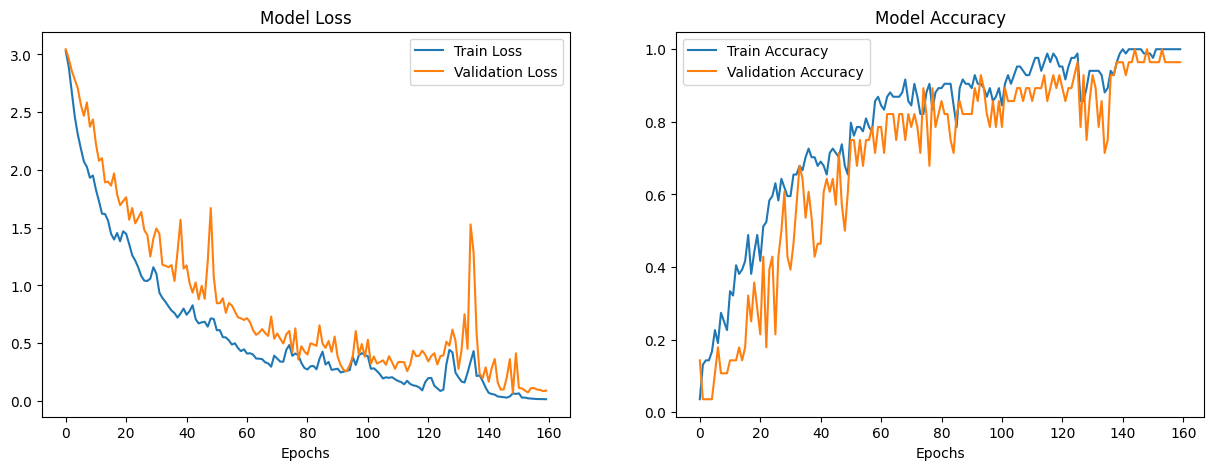

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss'); ax1.set_xlabel('Epochs'); ax1.legend()
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy'); ax2.set_xlabel('Epochs'); ax2.legend()
plt.show()

## Evaluation on the Test Set

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# --- 1. Load the Best Saved Model ---
model = Model(
    num_landmarks=TOTAL_LANDMARKS,
    landmark_dim=LANDMARK_DIM,
    hidden_size=HIDDEN_UNITS,
    num_layers=LSTM_LAYERS,
    num_classes=NUM_CLASSES,
    num_heads=ATTENTION_HEADS
)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.to(device)
model.eval()

# --- 2. Evaluate on the Test Loader ---
all_preds = []
all_labels = []
detailed_results = [] # To store (predicted_idx, true_idx) for each sample

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Collect results for detailed printing
        for pred_idx, true_idx in zip(predicted.cpu().numpy(), labels.cpu().numpy()):
            detailed_results.append((pred_idx, true_idx))

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Define the list of all possible class indices (0 to 19)
all_class_indices = list(range(NUM_CLASSES))
class_names = list(label_to_int.keys())

print("\nClassification Report on Test Set:")
print(classification_report(
    all_labels,
    all_preds,
    labels=all_class_indices, # Explicitly tell the report all possible labels
    target_names=class_names,
    zero_division=0
))


Test Accuracy: 1.0000

Classification Report on Test Set:
              precision    recall  f1-score   support

    hài_lòng       1.00      1.00      1.00         1
     kỹ_năng       1.00      1.00      1.00         2
      súp_lơ       0.00      0.00      0.00         0
khuyến_khích       1.00      1.00      1.00         2
  bánh_tráng       1.00      1.00      1.00         1
    khả_năng       1.00      1.00      1.00         2
   nhập_khẩu       1.00      1.00      1.00         3
   nhân_viên       1.00      1.00      1.00         1
     hấp_dẫn       1.00      1.00      1.00         3
     tự_giác       1.00      1.00      1.00         1
     bún_đậu       1.00      1.00      1.00         1
      ông_bà       0.00      0.00      0.00         0
      đầu_tư       1.00      1.00      1.00         2
     háo_hức       1.00      1.00      1.00         2
    hữu_nghị       0.00      0.00      0.00         0
 khởi_nghiệp       0.00      0.00      0.00         0
      đại_sứ       1.00

In [ ]:
# ==============================================================================
# 3. Print Wrongly Predicted Words and Correctly Predicted Words
# ==============================================================================
print("\n--- Detailed Prediction Analysis ---")
wrong_predictions_count = 0
correct_predictions_count = 0

print("\nWrong Predictions:")
if not detailed_results:
    print("  No test samples processed.")

for i, (predicted_idx, true_idx) in enumerate(detailed_results):
    predicted_word = int_to_label[predicted_idx]
    true_word = int_to_label[true_idx]

    if predicted_idx != true_idx:
        wrong_predictions_count += 1
        # Optionally, you could print the sample index or file name if available
        print(f"  Sample {i+1}: Predicted '{predicted_word}', Actual '{true_word}'")
    else:
        correct_predictions_count += 1

if wrong_predictions_count == 0:
    print("  No wrong predictions! Model achieved 100% accuracy on the test set.")

print(f"\nTotal Wrong Predictions: {wrong_predictions_count}")
print(f"Total Correct Predictions: {correct_predictions_count}")

# Optionally, you can also print a list of all correct ones, but it can be very long.
# If you want to see them:
print("\nCorrect Predictions:")
for i, (predicted_idx, true_idx) in enumerate(detailed_results):
    if predicted_idx == true_idx:
        predicted_word = int_to_label[predicted_idx]
        true_word = int_to_label[true_idx]
        print(f"  Sample {i+1}: Predicted '{predicted_word}', Actual '{true_word}'")


--- Detailed Prediction Analysis ---

Wrong Predictions:
  No wrong predictions! Model achieved 100% accuracy on the test set.

Total Wrong Predictions: 0
Total Correct Predictions: 28

Correct Predictions:
  Sample 1: Predicted 'nhập_khẩu', Actual 'nhập_khẩu'
  Sample 2: Predicted 'hấp_dẫn', Actual 'hấp_dẫn'
  Sample 3: Predicted 'kỹ_năng', Actual 'kỹ_năng'
  Sample 4: Predicted 'kỹ_năng', Actual 'kỹ_năng'
  Sample 5: Predicted 'hấp_dẫn', Actual 'hấp_dẫn'
  Sample 6: Predicted 'tự_giác', Actual 'tự_giác'
  Sample 7: Predicted 'đầu_tư', Actual 'đầu_tư'
  Sample 8: Predicted 'hấp_dẫn', Actual 'hấp_dẫn'
  Sample 9: Predicted 'hài_lòng', Actual 'hài_lòng'
  Sample 10: Predicted 'thương_mại', Actual 'thương_mại'
  Sample 11: Predicted 'quan_sát', Actual 'quan_sát'
  Sample 12: Predicted 'quan_sát', Actual 'quan_sát'
  Sample 13: Predicted 'khuyến_khích', Actual 'khuyến_khích'
  Sample 14: Predicted 'háo_hức', Actual 'háo_hức'
  Sample 15: Predicted 'quan_sát', Actual 'quan_sát'
  Sample 1

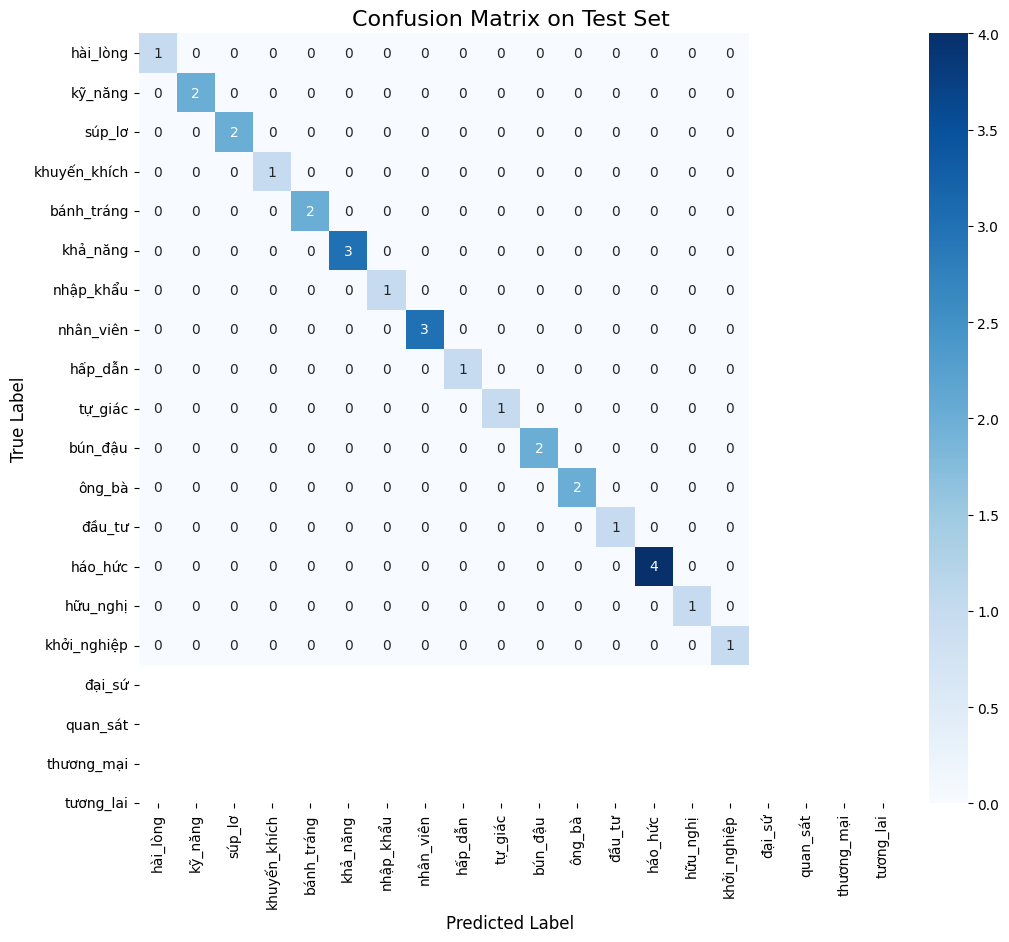

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. Compute the Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

# --- 2. Plot the Heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix on Test Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()